In [1]:
import numpy as np, pandas as pd
import os, sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
from datetime import datetime, date, time, timedelta
import utils

In [2]:
input_dir = "../data/"
output_dir = "../data/processed_orig_data/"


# Sine Data

In [3]:
selected = 'sine'

In [25]:
def gen_sine_data(no, seq_len, dim):   
    """Sine data generation.
    Args:
    - no: the number of samples
    - seq_len: sequence length of the time-series
    - dim: feature dimensions

    Returns:
    - data: generated data
    """ 
    size = (no, 1, dim)
    freq = np.random.uniform(0, .1, size)    
    phase = np.random.uniform(-1., 1., size)
    
    seq = np.arange(seq_len)
    seq = np.expand_dims(seq, axis=0)
    seq = np.expand_dims(seq, axis=-1)
    
    data = np.sin(2 * np.pi * freq * seq + phase)    
    data = (data + 1) * 0.5
    return data

In [5]:
def gen_sine_data (no, seq_len, dim):
  """Sine data generation.
  
  Args:
    - no: the number of samples
    - seq_len: sequence length of the time-series
    - dim: feature dimensions
    
  Returns:
    - data: generated data
  """  
  # Initialize the output
  data = list()

  # Generate sine data
  for i in range(no):      
    # Initialize each time-series
    temp = list()
    # For each feature
    for k in range(dim):
      # Randomly drawn frequency and phase
      freq = np.random.uniform(0, 0.1)            
      phase = np.random.uniform(0, 0.1)
          
      # Generate sine signal based on the drawn frequency and phase
      temp_data = [np.sin( 2 * np.pi * freq * j + phase) for j in range(seq_len)] 
      temp.append(temp_data)
        
    # Align row/column
    temp = np.transpose(np.asarray(temp))        
    # Normalize to [0,1]
    temp = (temp + 1)*0.5
    # Stack the generated data
    data.append(temp)
                
  return data

In [26]:
N, T, D = 10000, 24, 5 

In [27]:
TEST_PERC = 0.00
TRAIN_PERC = 1- TEST_PERC

perc_of_train_data = [2, 5, 10, 20, 100]

In [28]:
for p in perc_of_train_data:
    N_small = int(N * p / 100)
    sine_data = gen_sine_data(N_small, T, D)
    sine_data = np.array(sine_data)
    
    np.random.shuffle(sine_data)    
    print(sine_data.shape)
    
    fname = f'{selected}_subsampled_train_perc_{p}.npz'
    full_path = os.path.join(output_dir, fname)
    print(full_path)
    
#     np.save(full_path, sine_data)
    np.savez_compressed(full_path, data=sine_data)

(200, 24, 5)
../data/processed_orig_data/sine_subsampled_train_perc_2.npz
(500, 24, 5)
../data/processed_orig_data/sine_subsampled_train_perc_5.npz
(1000, 24, 5)
../data/processed_orig_data/sine_subsampled_train_perc_10.npz
(2000, 24, 5)
../data/processed_orig_data/sine_subsampled_train_perc_20.npz
(10000, 24, 5)
../data/processed_orig_data/sine_subsampled_train_perc_100.npz


# Preprocess Air Quality Data

Need to convert the data to have a single time column. Original data has Date and Time in separate columns.

In [36]:
air = pd.read_csv(f"{input_dir}AirQualityUCI.csv")
air.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


In [37]:
def parse_time_from_string(time_string,  format = '%H:%M:%S'):
    return datetime.strptime(time_string, format).time()

def parse_date_from_string(date_string, format='%m/%d/%Y'):
    return datetime.strptime(date_string, format)     # '%Y-%m-%d'

In [38]:
air['Date'] = air['Date'].apply(parse_date_from_string)
air['Time'] = air['Time'].apply(parse_time_from_string)

air['DateTime'] = air.apply(lambda row: datetime.combine(row['Date'], row['Time']), axis=1 )

air.drop(columns = ['Date', 'Time'], inplace=True)
air.head()

air.to_csv(f"{input_dir}/AirQualityUCI_processed.csv", index=False)

# Energy and Stock Data

In [39]:
data_dict = {
    'energy': {
        'file': 'Energy-energydata_complete.csv',
        'time_col': 'date',
    },
    'stocks': {
        'file': 'stock_data.csv',
        'time_col': None, 
    },
    'air': {
        'file': 'AirQualityUCI_processed.csv',
        'time_col': 'DateTime',
    },
}

### Choose Data

In [64]:
# selected = 'energy'
# selected = 'stocks'
selected = 'air'

In [65]:
file_path = os.path.join(input_dir, data_dict[selected]['file'])

if data_dict[selected]['time_col'] is not None: 
    data = pd.read_csv(file_path, parse_dates=[data_dict[selected]['time_col']])
else:
    data = pd.read_csv(file_path)
print(data.head())

   CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0     2.6         1360       150      11.9           1046      166   
1     2.0         1292       112       9.4            955      103   
2     2.2         1402        88       9.0            939      131   
3     2.2         1376        80       9.2            948      172   
4     1.6         1272        51       6.5            836      131   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  \
0          1056      113          1692         1268  13.6  48.9  0.7578   
1          1174       92          1559          972  13.3  47.7  0.7255   
2          1140      114          1555         1074  11.9  54.0  0.7502   
3          1092      122          1584         1203  11.0  60.0  0.7867   
4          1205      116          1490         1110  11.2  59.6  0.7888   

             DateTime  
0 2004-03-10 18:00:00  
1 2004-03-10 19:00:00  
2 2004-03-10 20:00:00  
3 2004-03-10 21:00:00  
4 2004-0

In [66]:
print("data shape: ", data.shape)

data shape:  (9357, 14)


### Sort data by time

In [67]:
time_col = data_dict[selected]['time_col']
print(time_col)

DateTime


In [68]:
if time_col in data: 
    data.sort_values(by=time_col, inplace=True)
    data.reset_index(drop=True, inplace=True)

### Delete the time col

In [69]:
if time_col in data: del data[time_col]
print("data shape: ", data.shape)

data shape:  (9357, 13)


### Train Test Split

In [70]:
N = data.shape[0]

frac_datasets = []
for p in perc_of_train_data: 
    
    num_test = int(N * TEST_PERC)   # to be held-out
    orig_num_train = N - num_test
    
    test_data = data.tail(num_test)  # to be used for evaluation later
    
    orig_train_data = data.loc[np.arange(orig_num_train)]
    #print(orig_train_data.shape)
    
    num_train_frac = int(orig_num_train * p / 100.)
    #print(f'Num train steps for p = {p} is {num_train_frac}')
    
    train_data_frac = data.tail(num_train_frac) 
    frac_datasets.append(train_data_frac)
    print(f'frac:{p}%, train_data_frac shape: {train_data_frac.shape}' )
    
    #np.save(os.path.join(data_dir, f'{selected}_train_perc_{p}.npy'), train_data_frac)

frac:2%, train_data_frac shape: (187, 13)
frac:5%, train_data_frac shape: (467, 13)
frac:10%, train_data_frac shape: (935, 13)
frac:20%, train_data_frac shape: (1871, 13)
frac:100%, train_data_frac shape: (9357, 13)


### Convert to 3D tensors
shape = N, T, D 

In [71]:
for i, d in enumerate(frac_datasets):
    frac_datasets[i] = d.values.reshape(1, *d.shape)
    print("reshaped: ", frac_datasets[i].shape)

reshaped:  (1, 187, 13)
reshaped:  (1, 467, 13)
reshaped:  (1, 935, 13)
reshaped:  (1, 1871, 13)
reshaped:  (1, 9357, 13)


### Create Subsampled series of required seq_len

In [72]:
target_len = 24
for p, d in zip(perc_of_train_data, frac_datasets):
    subsampled_dataset = []
    for idx in range(d.shape[1] - T):
        ser = d[:, idx: idx+T, :]
        subsampled_dataset.append(ser)
    subsampled_dataset = np.concatenate(subsampled_dataset, axis=0)
    print('p:', p, '3d tensor shape:', subsampled_dataset.shape)
    
    np.savez_compressed(os.path.join(f'{output_dir}/{selected}_subsampled_train_perc_{p}.npz'), data=subsampled_dataset)

p: 2 3d tensor shape: (163, 24, 13)
p: 5 3d tensor shape: (443, 24, 13)
p: 10 3d tensor shape: (911, 24, 13)
p: 20 3d tensor shape: (1847, 24, 13)
p: 100 3d tensor shape: (9333, 24, 13)


# Loading data

In [75]:
selected = 'energy'
loaded = np.load(f'{output_dir}{selected}_subsampled_train_perc_100.npz')
data = loaded['data']
print(data.shape)
data[0, 0]

(19711, 24, 28)


array([ 60.        ,  30.        ,  19.89      ,  47.59666667,
        19.2       ,  44.79      ,  19.79      ,  44.73      ,
        19.        ,  45.56666667,  17.16666667,  55.2       ,
         7.02666667,  84.25666667,  17.2       ,  41.62666667,
        18.2       ,  48.9       ,  17.03333333,  45.53      ,
         6.6       , 733.5       ,  92.        ,   7.        ,
        63.        ,   5.3       ,  13.27543316,  13.27543316])

In [76]:
selected = 'sine'
loaded = np.load(f'{output_dir}{selected}_subsampled_train_perc_100.npz')
data = loaded['data']
print(data.shape)

(10000, 24, 5)


(200, 24, 5)
generated mean :  [0.60217001 0.57762143 0.60308351 0.59334335 0.60308681]


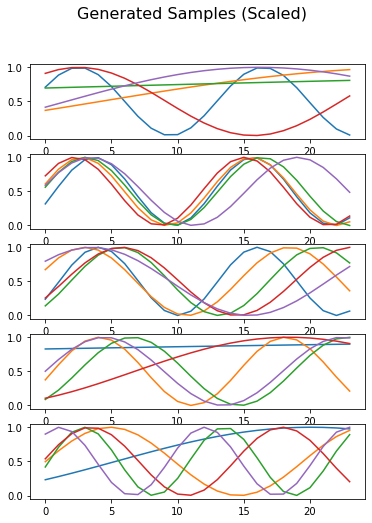

In [29]:
selected = 'sine'
perc = 2

loaded = np.load(f'{output_dir}{selected}_subsampled_train_perc_{perc}.npz')
gen_data = loaded['data']
print(gen_data.shape)

print("generated mean : ", gen_data.mean(axis=0).mean(axis=0)) 

utils.plot_samples(gen_data, n=5)